# Deep Learning-Based Groundwater Level prediction for the Virginia Eastern Shore


**Objective**: Prepare a dataset for predicting groundwater depth(feet) below ground surface based on weather variables.

**Scope**: Examine four USGS monitoring wells and weather data on the Eastern Shore of Virginia.

**Challenge**:The primary challenge in this datasets arise from having two different tempral resolution. The target data (Groundwater depth) is recorded at 15-minute intervals with mixed timezones (EST/EDT), while the feature data (Weather) is is available daily. Therefore before merging the groundwater depth and weather data resampling of the monitoring well data should be done.

# 1. Location Information

### USGS Monitoring Well Locations
The USGS monitoring wells used this project are listed below, including the USGS site ID
* Withams (USGS 375723075344404)
* Green Bush (USGS 374425075400003)
* Church Neck (USGS 372705075555903)
* Cape Charles (USGS 371543076003401)

In this section the geographic locations of the four  USGS monitoring wells used in this capstone project are retrived.The metadata  such as Latitude and Longitude are retrieved from the USGS Nationa Water Information System (NWIS).The locations identified will be used for visualizing geographically and to provide a geographical context for the groundwater data collected at each site.

### Imports and site metadata

In [13]:
import pandas as pd
import requests
import folium
from pathlib import Path

In [14]:
# USGS site IDs for groundwater monitoring wells
sites = {
    "Withams": "375723075344404",
    "Green Bush": "374425075400003",
    "Church Neck": "372705075555903",
    "Cape Charles": "371543076003401"
}

### Retrieve latitude and longitude from USGS NWIS

In [15]:
site_locations = []

for name, site_id in sites.items():
    url = (
        "https://waterservices.usgs.gov/nwis/site/"
        f"?format=rdb&sites={site_id}&siteOutput=expanded"
    )
    
    try:
        # Read USGS RDB format; comment lines start with '#'
        df = pd.read_csv(url, sep="\t", comment="#")
        
        # Filter to the actual site record (agency code = USGS)
        site_data = df[df["agency_cd"] == "USGS"].iloc[0]
        
        site_locations.append({
            "site_name": name,
            "usgs_id": site_id,
            "latitude": site_data["dec_lat_va"],
            "longitude": site_data["dec_long_va"]
        })
        
    except Exception as e:
        print(f"Error retrieving data for {name}: {e}")


### Create a structured DataFrame

In [16]:
locations_df = pd.DataFrame(site_locations)
locations_df

,site_name,usgs_id,latitude,longitude
0,Withams,375723075344404,37.95665,-75.57874444
1,Green Bush,374425075400003,37.74013889,-75.66549167
2,Church Neck,372705075555903,37.45197222,-75.93284444
3,Cape Charles,371543076003401,37.26209444,-76.00890556


### Convert latitude and longitude to numeric

In [17]:
locations_df["latitude"] = pd.to_numeric(locations_df["latitude"], errors="coerce")
locations_df["longitude"] = pd.to_numeric(locations_df["longitude"], errors="coerce")


### Create the geographic locations of the Withams, Green Bush, Church Neck and Cape Charles wells

In [18]:
base_map = folium.Map(
    location=[
        locations_df["latitude"].mean(),
        locations_df["longitude"].mean()
    ],
    zoom_start=9
)


In [19]:
for _, row in locations_df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["site_name"]
    ).add_to(base_map)
base_map


### Groundwater well State, County, Depth and aquifer type

In [72]:
from io import StringIO

rows = []
for name, site_id in sites.items():
    url = f"https://waterservices.usgs.gov/nwis/site/?format=rdb&sites={site_id}&siteOutput=expanded"
    r = requests.get(url)
    if not r.ok: continue
    
    lines = [l for l in r.text.splitlines() if not l.startswith("#")]
    df = pd.read_csv(StringIO('\n'.join([lines[0], lines[2]])), sep="\t")

    rows.append({
        "Site": name,
        "State": "Virginia" if df.get("state_cd", [0])[0] == 51 else "N/A",
        "County": "Accomack" if str(df.get("county_cd", [0])[0]) == "1" else "Northampton",
        "Well depth (ft)": df.get("well_depth_va", ["N/A"])[0],
        "Local aquifer": df.get("aqfr_nm", ["N/A"])[0],
        "Local aquifer type": {"C":"Confined","U":"Unconfined"}.get(df.get("aqfr_type_cd", [""])[0], "N/A"),
        "National aquifer": df.get("nat_aqfr_nm", ["N/A"])[0]
    })

#  drop  N/A
metadata_df = pd.DataFrame(rows).replace("N/A", pd.NA).dropna(axis=1, how='all').fillna("N/A")
metadata_df


,Site,State,County,Well depth (ft),Local aquifer type
0,Withams,Virginia,Accomack,36.0,Unconfined
1,Green Bush,Virginia,Accomack,315.0,Confined
2,Church Neck,Virginia,Northampton,37.0,Unconfined
3,Cape Charles,Virginia,Northampton,190.0,Confined


# 2. Raw Data Inspection and Cleaning

Groundwater depth data were collected at 15 minute intervals for the following USGS Monitoring wells (https://dashboard.waterdata.usgs.gov/app/nwd/en/): This data will be used as a target in the ML modeling.
* Withams (USGS 375723075344404)
* Green Bush (USGS 374425075400003)
* Church Neck (USGS 372705075555903)
* Cape Charles (USGS 371543076003401) 

Data related to the independent variables were collected at daily intervals from Open-Meteo Historical Weather API (https://open-meteo.com/):

* Evapotranspiration
* Mean soil moisture
* Mean air temperature
* Mean soil temperature
* Surface pressure
* Wind speed
* Vapor pressure deficit
* Wet-bulb temperature
  
From now on, I am using simple and consistent naming conventions to represent the monitoring wells without space and all small letter ('withams' = Withams, 'greenbush' = Green Bush, 'churchneck' = Church Neck, and 'capecharles' = Cape Charles). This names allow me to easily reference them as keys in a dictionary or columns in a DataFrame or as labels on a model

### Monitoring Well Data

### Initial Setup

In [20]:
# lists of wells where all the 4 data live
raw_path = Path("../data/raw/rawRenamed")
wells = ['withams', 'greenbush', 'churchneck', 'capecharles']

### Load the data

In [21]:
for name in wells:
    # 1. Load raw 15-min well data 
    file_path = raw_path / f"{name}.txt"
    df_gw = pd.read_csv(file_path, sep='\t', low_memory=False)
    display(df_gw.head())

,agency_cd,site_no,datetime,tz_cd,148149_72019,148149_72019_cd
0,USGS,375723075344404,2007-10-01 01:00,EDT,10.34,A
1,USGS,375723075344404,2007-10-01 01:15,EDT,10.34,A
2,USGS,375723075344404,2007-10-01 01:30,EDT,10.34,A
3,USGS,375723075344404,2007-10-01 01:45,EDT,10.34,A
4,USGS,375723075344404,2007-10-01 02:00,EDT,10.34,A


,agency_cd,site_no,datetime,tz_cd,148149_72019,148149_72019_cd
0,USGS,374425075400003,2007-10-01 01:00,EDT,89.13,A
1,USGS,374425075400003,2007-10-01 01:15,EDT,89.12,A
2,USGS,374425075400003,2007-10-01 01:30,EDT,89.09,A
3,USGS,374425075400003,2007-10-01 01:45,EDT,89.06,A
4,USGS,374425075400003,2007-10-01 02:00,EDT,89.03,A


,agency_cd,site_no,datetime,tz_cd,148149_72019,148149_72019_cd
0,USGS,372705075555903,2007-10-01 01:00,EDT,7.31,A
1,USGS,372705075555903,2007-10-01 01:15,EDT,7.30,A
2,USGS,372705075555903,2007-10-01 01:30,EDT,7.30,A
3,USGS,372705075555903,2007-10-01 01:45,EDT,7.30,A
4,USGS,372705075555903,2007-10-01 02:00,EDT,7.30,A


,agency_cd,site_no,datetime,tz_cd,148149_72019,148149_72019_cd
0,USGS,371543076003401,2007-10-01 01:00,EDT,13.18,A
1,USGS,371543076003401,2007-10-01 01:15,EDT,13.17,A
2,USGS,371543076003401,2007-10-01 01:30,EDT,13.17,A
3,USGS,371543076003401,2007-10-01 01:45,EDT,13.17,A
4,USGS,371543076003401,2007-10-01 02:00,EDT,13.17,A


In [22]:
from IPython.display import display
from IPython.core.display import HTML
heads = {}

for name in wells:
    file_path = raw_path / f"{name}.txt"
    df_gw = pd.read_csv(file_path, sep='\t', low_memory=False)
    heads[name.upper()] = df_gw.head()

df_heads = pd.concat(heads, axis=1)
display(df_heads)

WITHAMS                                                        \
  agency_cd          site_no          datetime tz_cd 148149_72019   
0      USGS  375723075344404  2007-10-01 01:00   EDT        10.34   
1      USGS  375723075344404  2007-10-01 01:15   EDT        10.34   
2      USGS  375723075344404  2007-10-01 01:30   EDT        10.34   
3      USGS  375723075344404  2007-10-01 01:45   EDT        10.34   
4      USGS  375723075344404  2007-10-01 02:00   EDT        10.34   

                  GREENBUSH                                           ...  \
  148149_72019_cd agency_cd          site_no          datetime tz_cd  ...   
0               A      USGS  374425075400003  2007-10-01 01:00   EDT  ...   
1               A      USGS  374425075400003  2007-10-01 01:15   EDT  ...   
2               A      USGS  374425075400003  2007-10-01 01:30   EDT  ...   
3               A      USGS  374425075400003  2007-10-01 01:45   EDT  ...   
4               A      USGS  374425075400003  2007-10-01 02:00   EDT  ...   

         CHURCHNECK                                    CAPECHARLES  \
           datetime tz_cd 148149_72019 148149_72019_cd   agency_cd   
0  2007-10-01 01:00   EDT         7.31               A        USGS   
1  2007-10-01 01:15   EDT         7.30               A        USGS   
2  2007-10-01 01:30   EDT         7.30               A        USGS   
3  2007-10-01 01:45   EDT         7.30               A        USGS   
4  2007-10-01 02:00   EDT         7.30               A        USGS   

                                                                         
           site_no          datetime tz_cd 148149_72019 148149_72019_cd  
0  371543076003401  2007-10-01 01:00   EDT        13.18               A  
1  371543076003401  2007-10-01 01:15   EDT        13.17               A  
2  371543076003401  2007-10-01 01:30   EDT        13.17               A  
3  371543076003401  2007-10-01 01:45   EDT        13.17               A  
4  371543076003401  2007-10-01 02:00   EDT        13.17               A  

[5 rows x 24 columns]

In [23]:
cols = [
    'agency_cd', 
    'site_no', 
    'datetime', 
    'tz_cd', 
    '148149_72019', 
    '148149_72019_cd'
]
existing_cols = cols
unique_counts = {
    name.upper(): df_gw[existing_cols].nunique()
    for name in wells
}

df_unique = pd.concat(unique_counts, axis=1)
display(df_unique)

,WITHAMS,GREENBUSH,CHURCHNECK,CAPECHARLES
agency_cd,1,1,1,1
site_no,1,1,1,1
datetime,631204,631204,631204,631204
tz_cd,2,2,2,2
148149_72019,470,470,470,470
148149_72019_cd,2,2,2,2


The column 148149 represnt USGS internal time series identifier. 72019 is the USGS parameter code for "Depth to water level, feet below land surface". The column 148149_72019_cd contain information related to time zone, 2 unique indicate the presence of both Eastern Standard Time (EST) and Eastern Daylight Time (EDT) within the record. Bacasue mixed time zone introduce temporal inconsistency, this should be addresed. The other fields (agency_cd, site_no, and other columns) are metadata and will be droped. 

Therfore the datset is reduced to two important fields:The timestamp and the groundwater depth. for clarity, datetime column is renamed to date and
148149_72019 column is renamed to depth_ft, which will be used as the target variable in the modeling.

In [24]:
shapes = {
    name.upper(): pd.Series(df_gw.shape, index=["Rows", "Columns"])
    for name in wells
}

df_shapes = pd.concat(shapes, axis=1)
display(df_shapes)

,WITHAMS,GREENBUSH,CHURCHNECK,CAPECHARLES
Rows,631280,631280,631280,631280
Columns,6,6,6,6


In [25]:
nulls = {
    name.upper(): df_gw.isnull().sum()
    for name in wells
}

df_nulls = pd.concat(nulls, axis=1)
display(df_nulls)

,WITHAMS,GREENBUSH,CHURCHNECK,CAPECHARLES
agency_cd,0,0,0,0
site_no,0,0,0,0
datetime,0,0,0,0
tz_cd,0,0,0,0
148149_72019,0,0,0,0
148149_72019_cd,0,0,0,0


### Timezone Handling

In [26]:
for name in wells:
# 1. Convert to datetime objects
    df_gw['datetime'] = pd.to_datetime(df_gw['datetime'], utc=True)

# 2. Convert to UTC 
    df_gw['datetime'] = df_gw['datetime'].dt.tz_convert('UTC')
    
# 3. Double-check for any NaT and drop
    df_gw = df_gw.dropna(subset=['datetime'])

### Drop duplicates for all 4 Monitoring Wells

In [27]:
well_data = {}
before_counts = {}

for name in wells:
    df_gw = pd.read_csv(raw_path / f"{name}.txt", sep='\t', low_memory=False, comment='#')
    if '5s' in str(df_gw.iloc[0, 0]): df_gw = df_gw.drop(index=0)
    
    # Store the dataframe and the count
    well_data[name] = df_gw
    before_counts[name] = len(df_gw)
    
    print(f"Loaded {name}: {before_counts[name]} rows")

Loaded withams: 623009 rows
Loaded greenbush: 608499 rows
Loaded churchneck: 634259 rows
Loaded capecharles: 631280 rows


In [28]:
# Drop duplicates to catch the double hour from daylight saving time(DST))
for name in wells:
    df_gw = well_data[name]
    df_gw['datetime'] = pd.to_datetime(df_gw['datetime'], utc=True)
    df_gw = df_gw.drop_duplicates(subset=['datetime'])
    
    # Save the cleaned version back into storage
    well_data[name] = df_gw
    print(f"Cleaned {name}")

Cleaned withams
Cleaned greenbush
Cleaned churchneck
Cleaned capecharles


In [29]:
results = []

for name in wells:
    df_gw = well_data[name]
    count_after = len(df_gw)
    count_before = before_counts[name] # Retrieve the specific 'before' count
    
    results.append({
        'Well': name.upper(),
        'Before': count_before,
        'After': count_after,
        'Removed': count_before - count_after
    })

# final table
import pandas as pd
display(pd.DataFrame(results))

,Well,Before,After,Removed
0,WITHAMS,623009,622933,76
1,GREENBUSH,608499,608423,76
2,CHURCHNECK,634259,634183,76
3,CAPECHARLES,631280,631204,76


### Resampling the Groundwater Depth data to Daily Mean
To ensure that the data are temporally consistent and to eliminate any artificial increase in predictor information, the groundwater depth data is averaged over each day to obtain a daily average value. Averaging the groundwater data over each day removed high frequency noise and preserved the major groundwater response to cumulative atmospheric and surface stresses.

The mixed parse dates is converted to UTC (Coordinated Universal Time).

In [30]:
depth_col = '148149_72019'

for name in wells:
    df_gw = well_data[name]
    
    # Convert depth to numbers 
    df_gw[depth_col] = pd.to_numeric(df_gw[depth_col], errors='coerce')
    
    # Simplify the table to just Date and Depth
    df_gw = df_gw[['datetime', depth_col]].rename(columns={'datetime': 'date', depth_col: 'gw_depth_ft'})
    
    # Save back to the dictionary
    well_data[name] = df_gw
    print(f" {name.upper()}: Numeric conversion complete.")

 WITHAMS: Numeric conversion complete.
 GREENBUSH: Numeric conversion complete.
 CHURCHNECK: Numeric conversion complete.
 CAPECHARLES: Numeric conversion complete.


In [31]:
#  dictionary to store the daily results
daily_wells = {}

for name in wells:
    df_gw = well_data[name]
    
    # Set the date as the index and sort it
    df_gw = df_gw.set_index('date').sort_index()
    
    # Resample to Daily Mean
    df_daily = df_gw['gw_depth_ft'].resample('D').mean().to_frame()
    
    # Store in the new dictionary
    daily_wells[name] = df_daily
    print(f" {name.upper()}: Resampled to {len(df_daily)} days.")

 WITHAMS: Resampled to 6667 days.
 GREENBUSH: Resampled to 6667 days.
 CHURCHNECK: Resampled to 6667 days.
 CAPECHARLES: Resampled to 6667 days.


In [32]:
df_head = pd.concat(
    {name.upper(): daily_wells[name].head() for name in wells},
    axis=1
)

display(df_head)


,WITHAMS,GREENBUSH,CHURCHNECK,CAPECHARLES
,gw_depth_ft,gw_depth_ft,gw_depth_ft,gw_depth_ft
date,,,,
2007-10-01 00:00:00+00:00,10.343152,88.186522,7.311413,13.170000
2007-10-02 00:00:00+00:00,10.352396,88.887708,7.324271,13.121146
2007-10-03 00:00:00+00:00,NaN,90.185000,7.339375,13.102917
2007-10-04 00:00:00+00:00,NaN,91.674688,7.358750,13.121458
2007-10-05 00:00:00+00:00,10.380349,92.744479,7.377083,13.134583


In [33]:
desc = {name.upper(): daily_wells[name].describe() for name in wells}
df_desc = pd.concat(desc, axis=1)
display(df_desc)


,WITHAMS,GREENBUSH,CHURCHNECK,CAPECHARLES
,gw_depth_ft,gw_depth_ft,gw_depth_ft,gw_depth_ft
count,6509.000000,6242.000000,6620.000000,6603.000000
mean,8.913328,97.311323,6.648034,10.737677
std,0.865860,4.397412,1.437491,1.038036
min,6.746667,75.747187,0.696250,8.662500
25%,8.236042,94.423438,5.860781,9.957396
50%,8.950000,97.670833,6.915156,10.692500
75%,9.566875,100.517734,7.668307,11.453594
max,11.092604,109.338958,9.260000,13.284062


In [34]:
for name in wells:
    missing_count = daily_wells[name]['gw_depth_ft'].isna().sum()
    total_days = len(daily_wells[name])
    percent_missing = (missing_count / total_days) * 100
    print(f"{name.upper()}: {missing_count} missing days out of {total_days} ({percent_missing:.2f}%)")

WITHAMS: 158 missing days out of 6667 (2.37%)
GREENBUSH: 425 missing days out of 6667 (6.37%)
CHURCHNECK: 47 missing days out of 6667 (0.70%)
CAPECHARLES: 64 missing days out of 6667 (0.96%)


### Fill Missing Values(Interpolation)

In [35]:
for name in wells:
    # Interpolate missing values
    daily_wells[name]['gw_depth_ft'] = daily_wells[name]['gw_depth_ft'].interpolate(method='linear')
    
    # Check if any NaNs remain exist
    remaining = daily_wells[name]['gw_depth_ft'].isna().sum()
    if remaining > 0:
        daily_wells[name]['gw_depth_ft'] = daily_wells[name]['gw_depth_ft'].bfill().ffill()
    
    print(f" {name.upper()}: Gaps filled.")

 WITHAMS: Gaps filled.
 GREENBUSH: Gaps filled.
 CHURCHNECK: Gaps filled.
 CAPECHARLES: Gaps filled.


In [36]:
for name in wells:
    final_nans = daily_wells[name]['gw_depth_ft'].isna().sum()
    print(f"{name.upper()} missing values: {final_nans}")

WITHAMS missing values: 0
GREENBUSH missing values: 0
CHURCHNECK missing values: 0
CAPECHARLES missing values: 0


### Univariate Analysis: Groundwater Depth

### Histogram (Distribution of groundwater Depth)
**a. Groundwater "Stability" (Spread)**

WITHAMS & CHURCH NECK: Both have a  small range (only approximately 3-8ft in total). This indicates high stability for these two wells, which could indicate influence by an adjacent or near-surface water body or shallow water table.
GREENBUSH: The groundwater depth range is much larger than the other wells, with values ranging from 75 ft to 110 ft. Compared to the other two wells, this well exhibits much greater variability in groundwater depth. This may result in the greatest difficulty when modeling this well due to its large swings.
CAPE CHARLES: The spread of this well's data appears to fall within a moderate range (approximately 4 ft) relative to the other wells, i.e., similar to that of Withams

**b. Modal Behavior**

Bimodal Trends: bimodal trends is obsaerved in both CHURCH NECK and CAPE CHARLES with two separate "peaks" in their histograms.

In many cases, groundwater behaves as such due to there being two distinct seasonal states: the first peak is associated with the "recharge" state (i.e., wet conditions) and the second peak represents the "discharge" state (i.e., dry conditions). 

Unimodal Trends (Bell Curve): GREENBUSH is virtually indistinguishable from a normal distribution (bell curve). In groundwater hydrology, unimodal behavior typically indicates that the groundwater system responds in a single, consistent manner (e.g., steady rain-infiltration into the soil).

**c. Skewness (Direction of the Tails)**

GREENBUSH and CHURCH NECK exhibit long tails toward the lower number end (i.e., shallower water). The presence of these long tails in both wells indicates that the wells can respond to rapid recharge ("flashy") events and subsequently drain back to the "peak".
Right-Skewed: WITHAMS displays a longer tail toward the higher number side (i.e., deeper water). The presence of a tail in the opposite direction of the previous two wells suggests that this well spends most of the time in a shallow condition, however it can periodically drop to a deeper state, possibly due to drought or localized pumping.

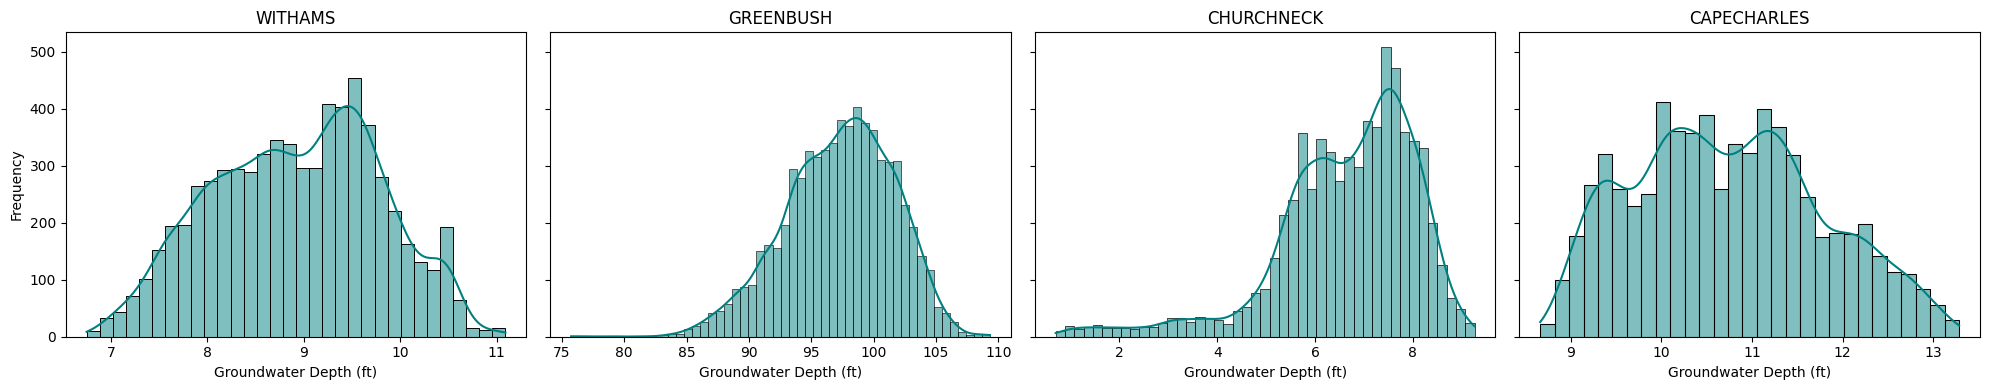

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(wells), figsize=(20, 4), sharey=True)

for ax, name in zip(axes, wells):
    sns.histplot(daily_wells[name]['gw_depth_ft'], kde=True, ax=ax, color='teal')
    ax.set_title(name.upper())
    ax.set_xlabel("Groundwater Depth (ft)")
    ax.set_ylabel("Frequency" if ax == axes[0] else "")

plt.tight_layout()
plt.show()


### Individual Well Ranges

In [38]:
for name in wells:
    col = daily_wells[name]['gw_depth_ft']
    w_min = col.min()
    w_max = col.max()
    w_range = w_max - w_min
    
    print(f"WELL: {name.upper()}")
    print(f"  Min Depth: {w_min:.2f} ft")
    print(f"  Max Depth: {w_max:.2f} ft")
    print(f"  Total Range: {w_range:.2f} ft")
    print("-" * 30)

WELL: WITHAMS
  Min Depth: 6.75 ft
  Max Depth: 11.09 ft
  Total Range: 4.35 ft
------------------------------
WELL: GREENBUSH
  Min Depth: 75.75 ft
  Max Depth: 109.34 ft
  Total Range: 33.59 ft
------------------------------
WELL: CHURCHNECK
  Min Depth: 0.70 ft
  Max Depth: 9.26 ft
  Total Range: 8.56 ft
------------------------------
WELL: CAPECHARLES
  Min Depth: 8.66 ft
  Max Depth: 13.28 ft
  Total Range: 4.62 ft
------------------------------


### BOX PLOTS

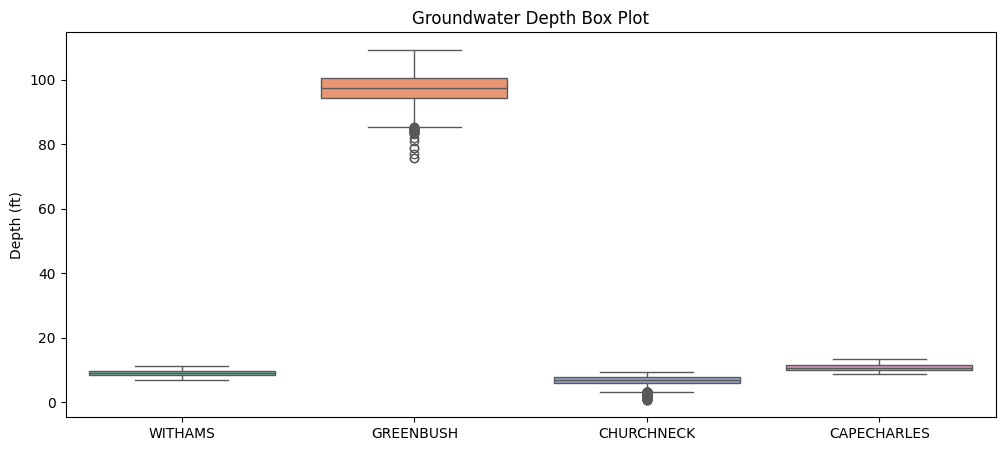

In [39]:
# Boxplot for statistical distribution
plt.figure(figsize=(12, 5))
df_box = pd.concat([daily_wells[name]['gw_depth_ft'].rename(name.upper()) for name in wells], axis=1)

sns.boxplot(data=df_box, palette="Set2")
plt.ylabel("Depth (ft)")
plt.title("Groundwater Depth Box Plot")
plt.show()

### Outlier Analysis
Data Range is from 2007 through 2025 and there were only 30 outliers for GREENBUSH and 229 for CHURCHNECK (from a total of 6,667 days), which is positive as it indicates that the data has a very low level of noise and/or error. The Outliers could be actual physical events such as extreme droughts, excessive recharge via irrigation or other means and therefore during the project the Outliers will be retained rather than removed.

In [40]:
for name in wells:
    df = daily_wells[name]
    
    # Calculate IQR
    Q1 = df['gw_depth_ft'].quantile(0.25)
    Q3 = df['gw_depth_ft'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds (Standard 1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df['gw_depth_ft'] < lower_bound) | (df['gw_depth_ft'] > upper_bound)]
    
    print(f"--- {name.upper()} ---")
    print(f"  Lower Bound: {lower_bound:.2f} | Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  Example Outlier Values: {outliers['gw_depth_ft'].head().values}")
    print("-" * 30)

--- WITHAMS ---
  Lower Bound: 6.29 | Upper Bound: 11.54
  Number of Outliers: 0
------------------------------
--- GREENBUSH ---
  Lower Bound: 85.24 | Upper Bound: 109.58
  Number of Outliers: 30
  Example Outlier Values: [85.12291667 83.46375    85.21854167 84.973125   83.9890625 ]
------------------------------
--- CHURCHNECK ---
  Lower Bound: 3.17 | Upper Bound: 10.37
  Number of Outliers: 229
  Example Outlier Values: [3.05822917 3.1121875  2.74989583 2.36020833 2.44458333]
------------------------------
--- CAPECHARLES ---
  Lower Bound: 7.70 | Upper Bound: 13.71
  Number of Outliers: 0
------------------------------


### TIME SERIES PLOT

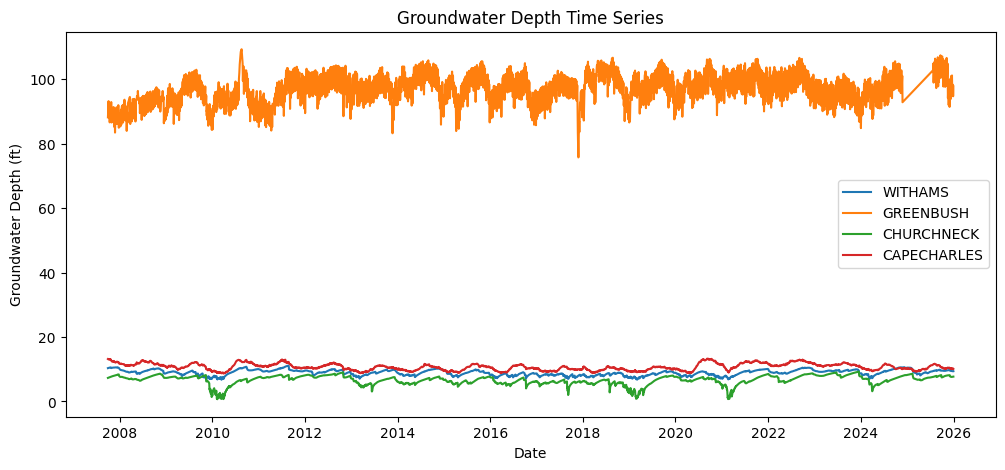

In [41]:
# Time series for historical trends
plt.figure(figsize=(12, 5))
for name in wells:
    plt.plot(daily_wells[name].index, daily_wells[name]['gw_depth_ft'], label=name.upper())

plt.xlabel("Date")
plt.ylabel("Groundwater Depth (ft)")
plt.title("Groundwater Depth Time Series")
plt.legend()
plt.show()

### Weather Data

### Initial Setup

In [42]:
# List of weather data 
weather_sites = ['withams_we', 'greenbush_we', 'churchneck_we', 'capecharles_we']

base_path = "../data/raw/rawRenamed/"

In [43]:
# Dictionary to store the dataframes 
weather_dfs = {}

for site in weather_sites:
    file_path = f"{base_path}{site}.csv"
    
    try:
        # Load the data
        df = pd.read_csv(file_path, encoding="latin1", parse_dates=["date"])
        weather_dfs[site] = df
        
        # Check for missing values
        missing_count = df.isnull().sum().sum()
        
        print(f"Loaded {site}: {len(df)} rows, {missing_count} missing values")
        
    except FileNotFoundError:
        print(f"Could not find: {file_path}")

Loaded withams_we: 6667 rows, 0 missing values
Loaded greenbush_we: 6667 rows, 0 missing values
Loaded churchneck_we: 6667 rows, 0 missing values
Loaded capecharles_we: 6667 rows, 0 missing values


In [44]:
## Column list 
cols = [
    'Evapotranspiration(inch)', 'Precipitation(inch)', 
    'Mean_soil_moisture(m^3/m^3)', 'Mean_temperaturen(°F)', 
    'Mean_surface_pressure(hPa)', 'Mean_wind_speed(mp/h)', 
    'Mean_soil_temperature(°F)', 'Max_vapour_pressure_deficit (kPa)', 
    'Mean_wet_bulb_temperature (°F)'
]

existing_cols = cols

# Generate the side-by-side table output
unique_counts = {
    name.upper(): weather_dfs[name][existing_cols].nunique()
    for name in weather_dfs
}

df_unique_weather = pd.concat(unique_counts, axis=1)
display(df_unique_weather)

,WITHAMS_WE,GREENBUSH_WE,CHURCHNECK_WE,CAPECHARLES_WE
Evapotranspiration(inch),281,271,277,277
Precipitation(inch),374,365,371,371
Mean_soil_moisture(m^3/m^3),239,241,248,248
Mean_temperaturen(°F),674,647,616,616
Mean_surface_pressure(hPa),415,408,416,416
Mean_wind_speed(mp/h),200,203,296,296
Mean_soil_temperature(°F),408,403,406,406
Max_vapour_pressure_deficit (kPa),340,312,270,270
Mean_wet_bulb_temperature (°F),635,618,603,603


### Univariate Analysis Weather Data

### Precipitation

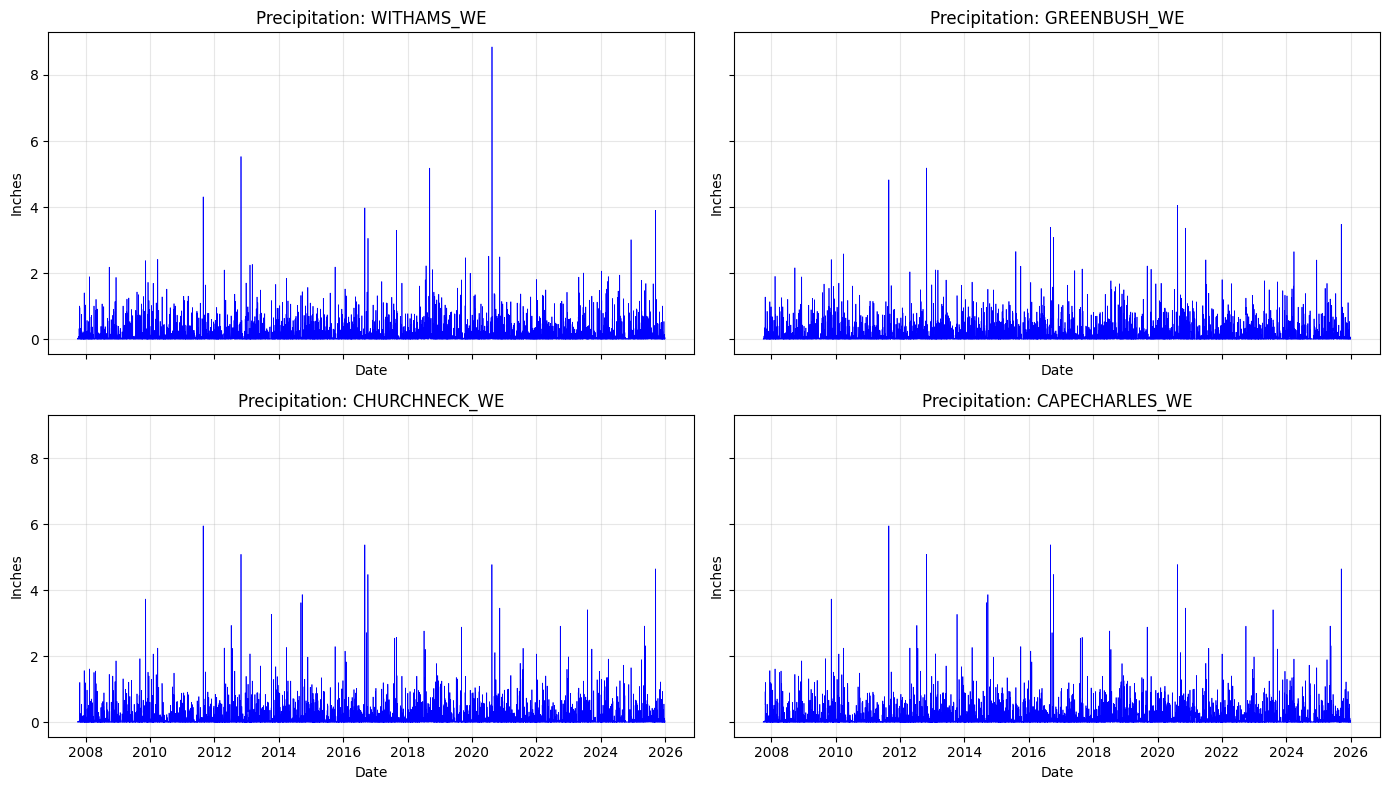

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, site in enumerate(weather_sites):
    ax = axes[i]
    df = weather_dfs[site]
    ax.plot(df['date'], df['Precipitation(inch)'], color='blue', linewidth=0.5)
    ax.set_title(f"Precipitation: {site.upper()}")
    ax.set_ylabel("Inches")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Soil Moisture

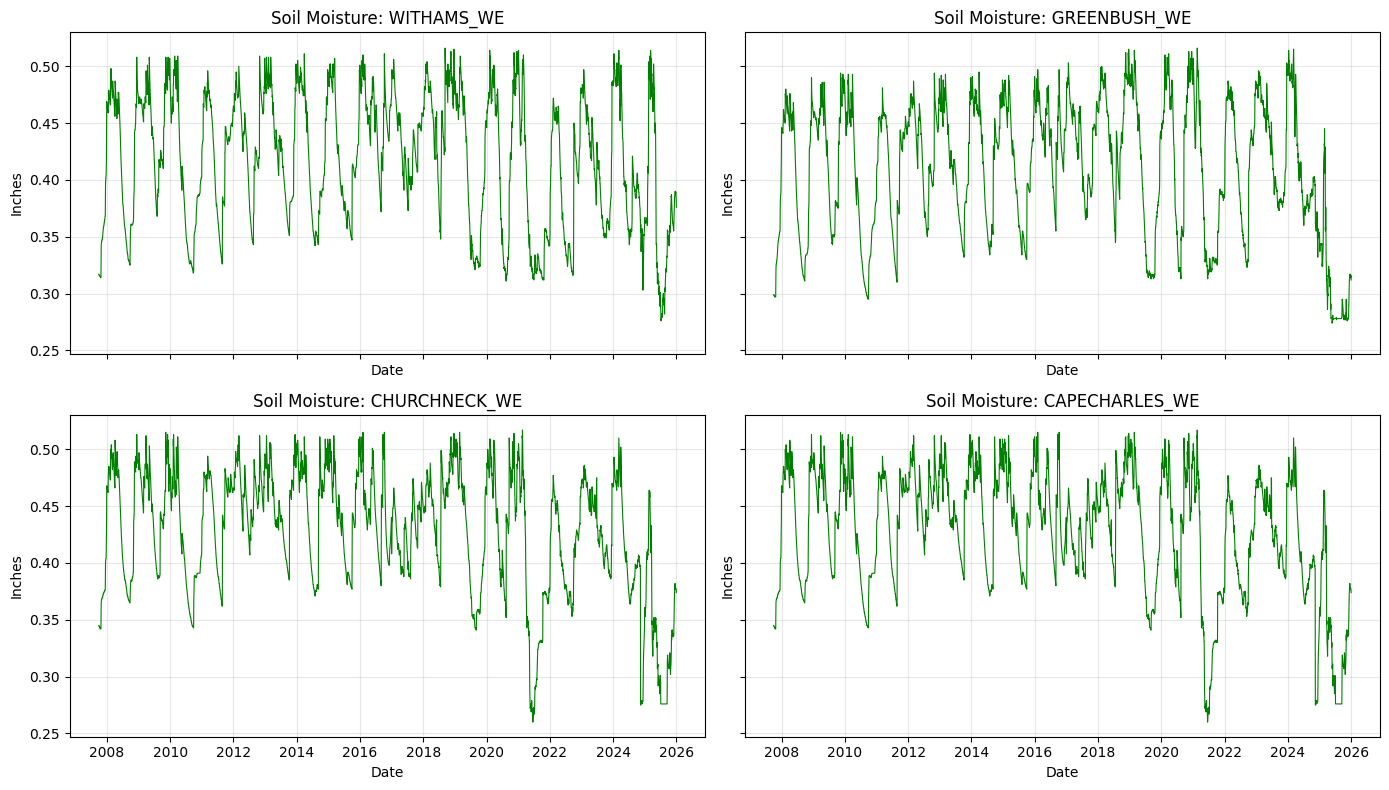

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, site in enumerate(weather_sites):
    ax = axes[i]
    df = weather_dfs[site]
    ax.plot(df['date'], df['Mean_soil_moisture(m^3/m^3)'], color='green', linewidth=0.8)
    ax.set_title(f"Soil Moisture: {site.upper()}")
    ax.set_ylabel("Inches")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

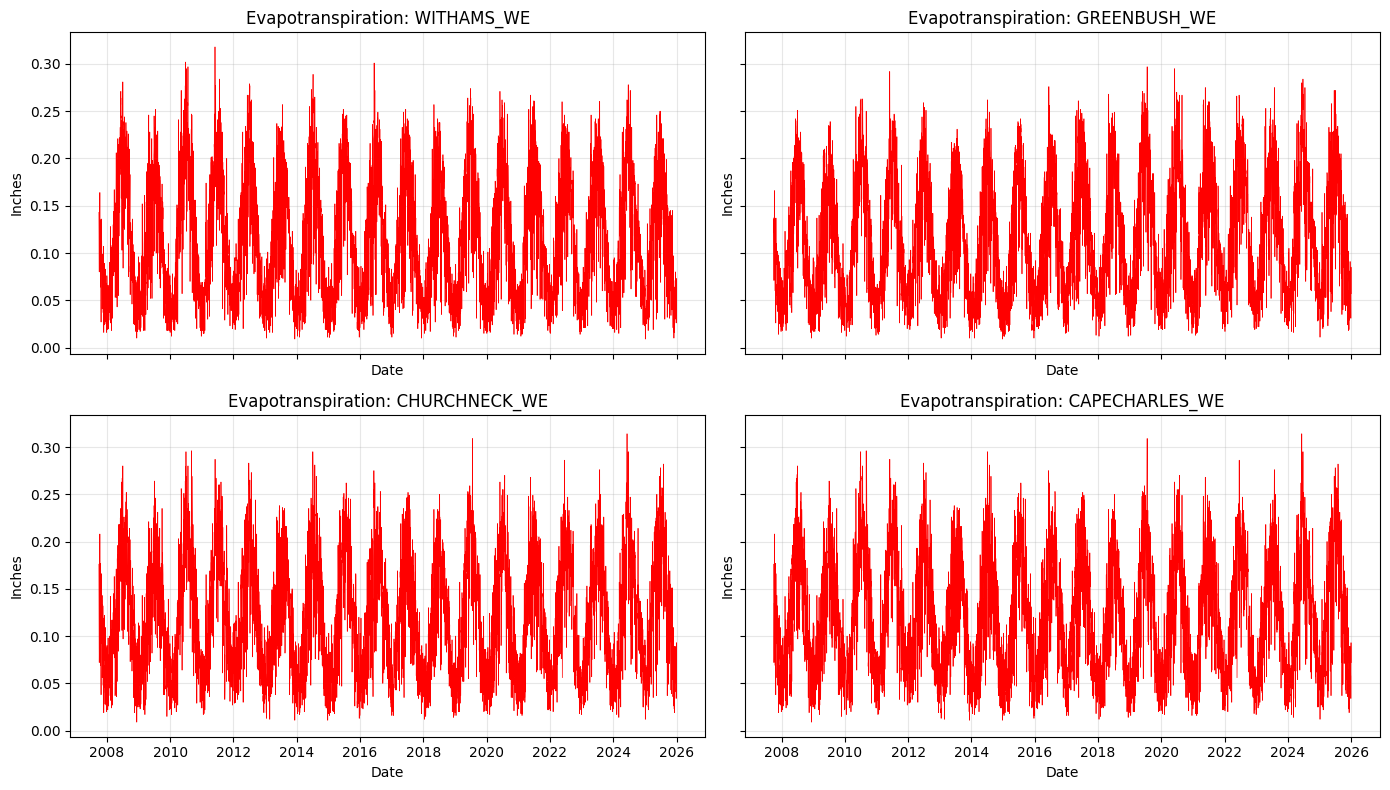

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, site in enumerate(weather_sites):
    ax = axes[i]
    df = weather_dfs[site]
    
    # Plotting Evapotranspiration (red to represent heat/loss)
    ax.plot(df['date'], df['Evapotranspiration(inch)'], color='red', linewidth=0.5)
    
    ax.set_title(f"Evapotranspiration: {site.upper()}")
    ax.set_ylabel("Inches")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Merge the Groundwater Depth with Weather data for each well
The USGS monitoring well sensor data, containing date and gw_depth_ft columns, were joined with the weather datasets, which includes nine independent variables, using date as index

In [48]:
merged_dfs = {}

for name in wells:
    # 1. Copy groundwater data
    df_gw = daily_wells[name].copy()
    
    # 2. Copy weather data and set index
    df_we = weather_dfs[f"{name}_we"].copy()
    if 'date' in df_we.columns:
        df_we = df_we.set_index('date')
    
    # 3. Timezone information from both indices
    if df_gw.index.tz is not None:
        df_gw.index = df_gw.index.tz_localize(None)
        
    if df_we.index.tz is not None:
        df_we.index = df_we.index.tz_localize(None)
    
    # 4. Join groundwater depth and weather data
    merged_dfs[name] = df_gw.join(df_we, how='inner')
    
    print(f" {name.upper()} merged successfully! (No timezone conflicts)")

 WITHAMS merged successfully! (No timezone conflicts)
 GREENBUSH merged successfully! (No timezone conflicts)
 CHURCHNECK merged successfully! (No timezone conflicts)
 CAPECHARLES merged successfully! (No timezone conflicts)


In [49]:
display(merged_dfs['withams'].head())

,gw_depth_ft,Evapotranspiration(inch),Precipitation(inch),Mean_soil_moisture(m^3/m^3),Mean_temperaturen(°F),Mean_surface_pressure(hPa),Mean_wind_speed(mp/h),Mean_soil_temperature(°F),Max_vapour_pressure_deficit (kPa),Mean_wet_bulb_temperature (°F)
date,,,,,,,,,,
2007-10-01,10.343152,0.143,0.000,0.317,67.7,1028.6,8.2,72.7,1.57,59.5
2007-10-02,10.352396,0.126,0.008,0.317,71.0,1024.3,8.1,72.5,1.56,65.4
2007-10-03,10.361714,0.119,0.012,0.317,74.2,1019.5,4.3,72.4,1.40,70.3
2007-10-04,10.371031,0.098,0.004,0.316,74.1,1021.1,4.2,72.5,1.34,70.7
2007-10-05,10.380349,0.080,0.031,0.316,73.5,1024.0,6.0,72.7,0.91,70.4


### Execution and Dictionary Storage

The merged dataset is saved and further preprossed for cleaning missing value and perform feature engineering

In [50]:
from pathlib import Path

# 1.destination folder
save_path = Path("../data/processed")
save_path.mkdir(parents=True, exist_ok=True)

# 2. Loop through each unique well and save 
for well_name, df in merged_dfs.items():
    # filename
    file_name = f"gw_{well_name}.csv"
    
    # Save to CSV
    df.to_csv(save_path / file_name)
    
    print(f" Saved {well_name} (Aquifer Data) to: {file_name}")

print("\nAll wells have been exported as separate datasets.")

 Saved withams (Aquifer Data) to: gw_withams.csv
 Saved greenbush (Aquifer Data) to: gw_greenbush.csv
 Saved churchneck (Aquifer Data) to: gw_churchneck.csv
 Saved capecharles (Aquifer Data) to: gw_capecharles.csv

All wells have been exported as separate datasets.


### Check for Missing Data after Merged
There area 40 missing gw_depth_ft. Its found that all the 40 missing values are from 'gw_Withams.csv'.

In [51]:
for name, df in merged_dfs.items():
    print(f"{name.upper()}: {df.isna().sum().sum()} missing values")

WITHAMS: 0 missing values
GREENBUSH: 0 missing values
CHURCHNECK: 0 missing values
CAPECHARLES: 0 missing values


### Groundwater depth vs Precipitation
The groundwater depth and precipitation time series plot shows that there is a strong lagged response in the eastern shore.

In Cape Charles, Churchneck and Withams sites; trends have shown that there is an increase in groundwater levels (i.e., become less deep) after heavy precipitation and decrease in groundwater levels (become more deep) when there is less precipitation.These results indicate that the aquifers located in these areas are generally shallow and respond well to surface recharge.

In Greenbush a long term decline trend was observed, as that site has been trending downward, and did not recover after significant precipitation events. Therefore, it appears that either localized extraction (pumping) or geological conditions within Greenbush are causing groundwater levels to remain declining.



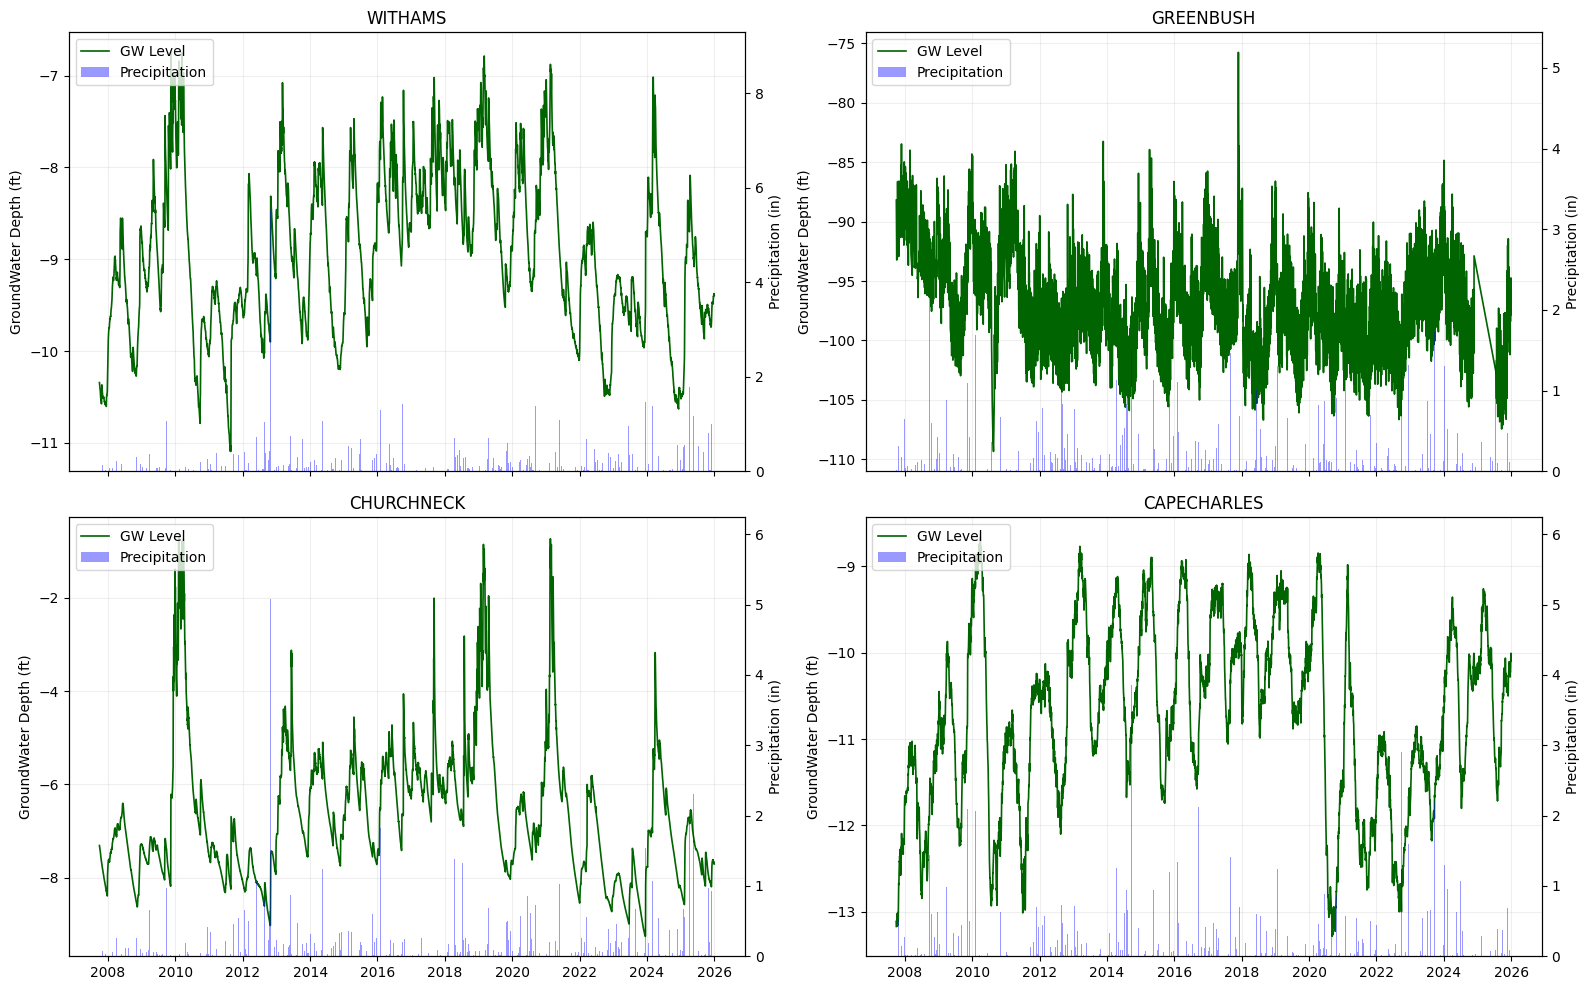

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for i, site in enumerate(wells):
    ax1 = axes[i]
    df = merged_dfs[site]
    
    # Left Axis: GW Level (multiplied by -1)
    ax1.plot(df.index, df['gw_depth_ft'] * -1, color='darkgreen', linewidth=1.2, label='GW Level')
    ax1.set_ylabel('GroundWater Depth (ft)')
    
    # Right Axis: Precipitation
    ax2 = ax1.twinx()
    ax2.bar(df.index, df['Precipitation(inch)'], color='blue', alpha=0.4, label='Precipitation')
    ax2.set_ylabel('Precipitation (in)')
    # legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper left')
    
    ax1.set_title(f"{site.upper()}")
    ax1.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()